In [1]:
import glob
import json
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.dataprocessing import get_measured_potential
from tensorflow import distribute as dist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    Normalization,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2024-03-11 12:14:13.411757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 12:14:13.411853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 12:14:13.412689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 12:14:13.498059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Acryl

In [2]:
# load empty tank measurements
empty_d_20 = np.sort(glob.glob("measurements/acryl_skip_8_d_20/empty_tank/*npz"))
empty_d_30 = np.sort(glob.glob("measurements/acryl_skip_8_d_30/empty_tank/*npz"))
empty_d_40 = np.sort(glob.glob("measurements/acryl_skip_8_d_40/empty_tank/*npz"))

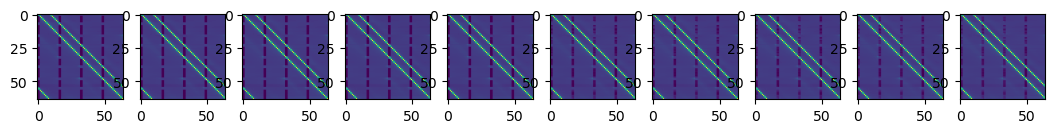

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(13, 5))

egnd_data_d_20 = list()
clrng_d_20 = list()

for i, ele in enumerate(empty_d_20):
    tmp = np.load(ele, allow_pickle=True)
    pot = get_measured_potential(tmp, shape_type="vector")
    egnd_data_d_20.append(pot)
    clrng_d_20.append(20)
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

clrng_d_20 = np.array(clrng_d_20)
egnd_data_d_20 = np.array(egnd_data_d_20)

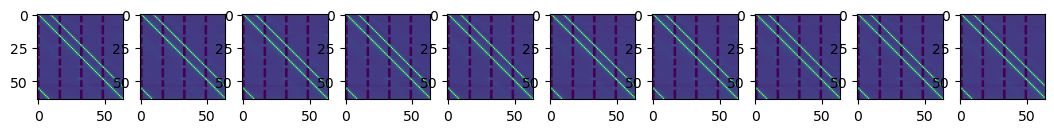

In [4]:
fig, ax = plt.subplots(1, 10, figsize=(13, 5))

egnd_data_d_30 = list()
clrng_d_30 = list()

for i, ele in enumerate(empty_d_30):
    tmp = np.load(ele, allow_pickle=True)
    pot = get_measured_potential(tmp, shape_type="vector")
    egnd_data_d_30.append(pot)
    clrng_d_30.append(30)
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

clrng_d_30 = np.array(clrng_d_30)
egnd_data_d_30 = np.array(egnd_data_d_30)

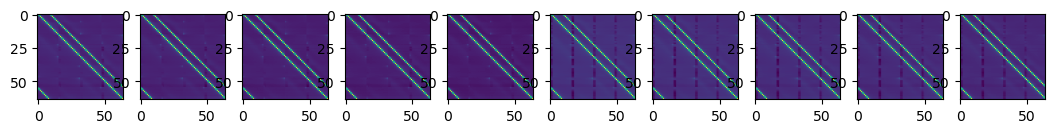

In [5]:
fig, ax = plt.subplots(1, 10, figsize=(13, 5))

egnd_data_d_40 = list()
clrng_d_40 = list()

for i, ele in enumerate(empty_d_40):
    tmp = np.load(ele, allow_pickle=True)
    pot = get_measured_potential(tmp, shape_type="vector")
    egnd_data_d_40.append(pot)
    clrng_d_40.append(40)
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

clrng_d_40 = np.array(clrng_d_40)
egnd_data_d_40 = np.array(egnd_data_d_40)

In [6]:
# compute the mean
mean_egnd_d_20 = np.mean(egnd_data_d_20, axis=0)
mean_egnd_d_30 = np.mean(egnd_data_d_30, axis=0)
mean_egnd_d_40 = np.mean(egnd_data_d_40, axis=0)

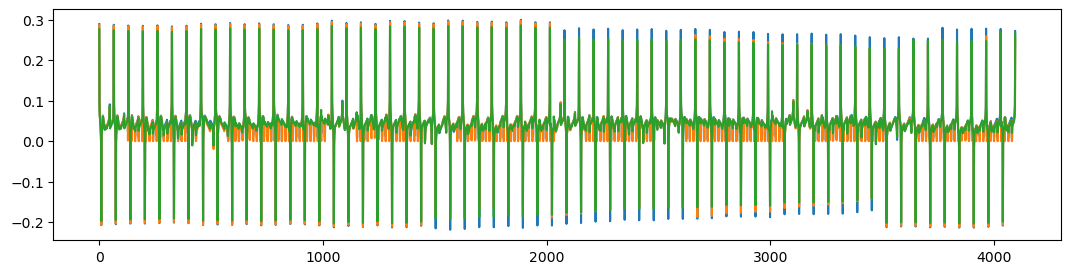

In [7]:
# plot all mean signals
plt.figure(figsize=(13, 3))
plt.plot(np.real(mean_egnd_d_20), color="C0")
plt.plot(np.real(mean_egnd_d_30), color="C1")
plt.plot(np.real(mean_egnd_d_40), color="C2")
plt.show()

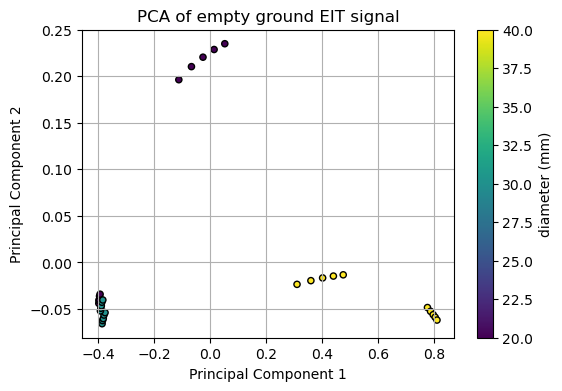

In [8]:
# plot the PCA of all empty ground measurements

gt_clrng = np.concatenate((clrng_d_20, clrng_d_30, clrng_d_40))
mean_egnd = np.concatenate((egnd_data_d_20, egnd_data_d_30, egnd_data_d_40))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.abs(mean_egnd))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gt_clrng, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of empty ground EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

In [9]:
# load all data points
d_20 = np.sort(glob.glob("measurements/acryl_skip_8_d_20/data/*npz"))
d_30 = np.sort(glob.glob("measurements/acryl_skip_8_d_30/data/*npz"))
d_40 = np.sort(glob.glob("measurements/acryl_skip_8_d_40/data/*npz"))

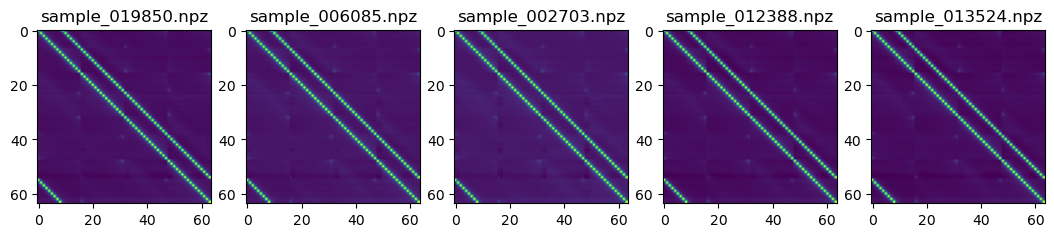

In [10]:
# plot five random datapoints from d_20/d_30/d_40
fig, ax = plt.subplots(1, 5, figsize=(13, 5))
for i in range(5):
    rand_ele = random.choice(d_20)
    tmp = np.load(rand_ele, allow_pickle=True)
    ax[i].set_title(rand_ele.split("/")[-1])
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

In [11]:
data_d_20 = list()
data_d_20_abs = list()
d_d_20 = list()

for ele in tqdm(d_20[::]):
    tmp = np.load(ele, allow_pickle=True)

    pot = get_measured_potential(tmp, shape_type="vector")

    data_d_20.append(pot - mean_egnd_d_20)
    data_d_20_abs.append(pot)

    d_d_20.append(tmp["anomaly"].tolist().d)

data_d_20 = np.array(data_d_20)
data_d_20_abs = np.array(data_d_20_abs)
d_d_20 = np.array(d_d_20)

100%|██████████| 20700/20700 [04:47<00:00, 72.12it/s]


In [12]:
data_d_30 = list()
data_d_30_abs = list()
d_d_30 = list()

for ele in tqdm(d_30[::]):
    tmp = np.load(ele, allow_pickle=True)

    pot = get_measured_potential(tmp, shape_type="vector")

    data_d_30.append(pot - mean_egnd_d_30)
    data_d_30_abs.append(pot)

    d_d_30.append(tmp["anomaly"].tolist().d)

data_d_30 = np.array(data_d_30)
data_d_30_abs = np.array(data_d_30_abs)
d_d_30 = np.array(d_d_30)

100%|██████████| 20700/20700 [04:14<00:00, 81.19it/s]


In [13]:
data_d_40 = list()
data_d_40_abs = list()
d_d_40 = list()

for ele in tqdm(d_40[::]):
    tmp = np.load(ele, allow_pickle=True)

    pot = get_measured_potential(tmp, shape_type="vector")

    data_d_40.append(pot - mean_egnd_d_40)
    data_d_40_abs.append(pot)

    d_d_40.append(tmp["anomaly"].tolist().d)

data_d_40 = np.array(data_d_40)
data_d_40_abs = np.array(data_d_40_abs)
d_d_40 = np.array(d_d_40)

100%|██████████| 20700/20700 [04:06<00:00, 83.82it/s]


In [14]:
X = np.concatenate((data_d_20, data_d_30, data_d_40))
X_abs = np.concatenate((data_d_20_abs, data_d_30_abs, data_d_40_abs))
y = np.concatenate((d_d_20, d_d_30, d_d_40))

print(X.shape, y.shape)

(62100, 4096) (62100,)


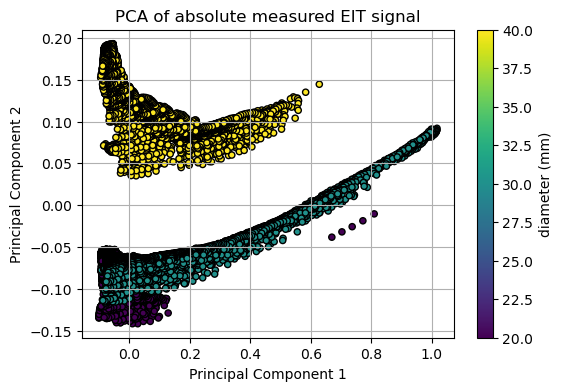

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.abs(X_abs))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of absolute measured EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

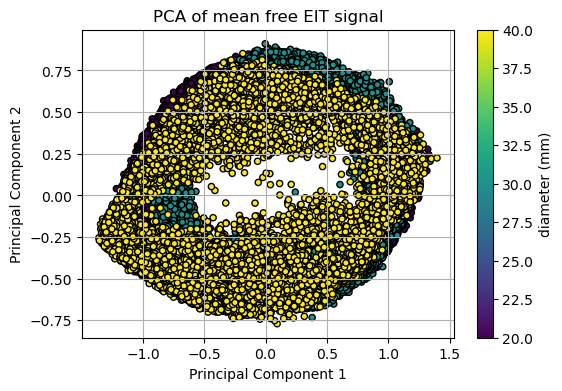

In [16]:
# PCA
pca = PCA(
    n_components=2
)  # You can change the number of components according to your needs
X_pca = pca.fit_transform(np.abs(X))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of mean free EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

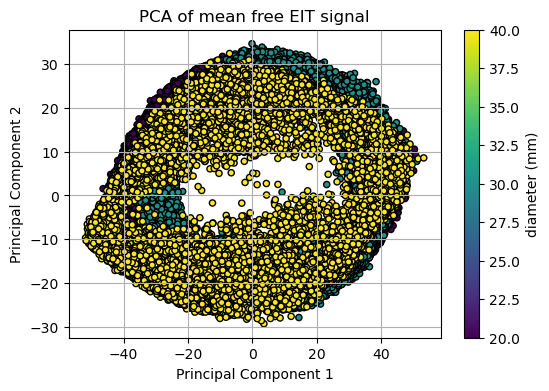

In [17]:
# PCA of the z-score normalization
pca = PCA(
    n_components=2
)  # You can change the number of components according to your needs
X_pca = pca.fit_transform((np.abs(X) - np.mean(np.abs(X))) / np.std(np.abs(X)))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of mean free EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

In [18]:
# Generate sample data (replace this with your own dataset)
pca = PCA(
    n_components=3
)  # You can change the number of components according to your needs
#X_pca = pca.fit_transform(np.abs(X_abs))
X_pca = pca.fit_transform(np.abs(X_abs))

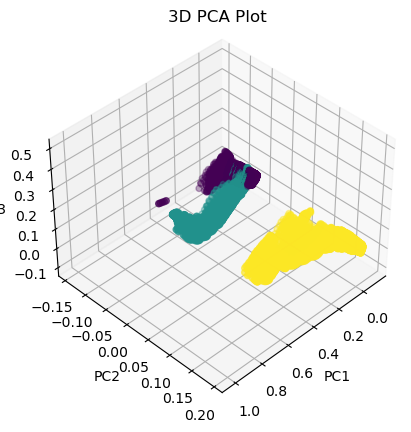

In [19]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.view_init(elev=40, azim=45)
plt.title("3D PCA Plot")
plt.show()

## Messingempty_d_20

In [20]:
# load empty tank measurements
empty_d_20 = np.sort(glob.glob("measurements/messing_skip_8_d_20/empty_tank/*npz"))
empty_d_30 = np.sort(glob.glob("measurements/messing_skip_8_d_30/empty_tank/*npz"))
empty_d_40 = np.sort(glob.glob("measurements/messing_skip_8_d_40/empty_tank/*npz"))

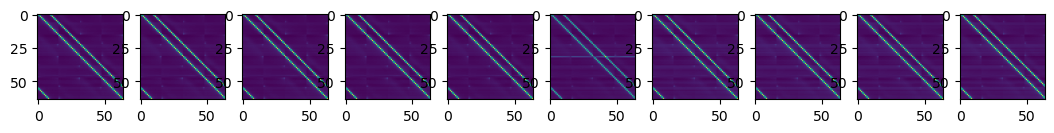

In [56]:
fig, ax = plt.subplots(1, 10, figsize=(13, 5))

egnd_data_d_20 = list()
clrng_d_20 = list()

for i, ele in enumerate(empty_d_20):
    tmp = np.load(ele, allow_pickle=True)
    pot = get_measured_potential(tmp, shape_type="vector")
    egnd_data_d_20.append(pot)
    clrng_d_20.append(20)
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

clrng_d_20 = np.array(clrng_d_20)
egnd_data_d_20 = np.array(egnd_data_d_20)

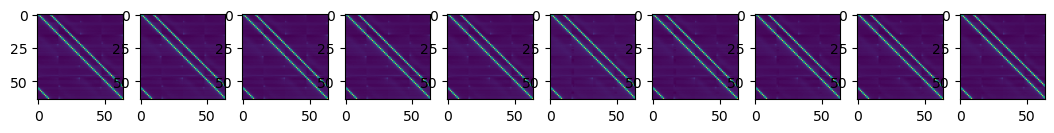

In [57]:
fig, ax = plt.subplots(1, 10, figsize=(13, 5))

egnd_data_d_30 = list()
clrng_d_30 = list()

for i, ele in enumerate(empty_d_30):
    tmp = np.load(ele, allow_pickle=True)
    pot = get_measured_potential(tmp, shape_type="vector")
    egnd_data_d_30.append(pot)
    clrng_d_30.append(30)
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

clrng_d_30 = np.array(clrng_d_30)
egnd_data_d_30 = np.array(egnd_data_d_30)

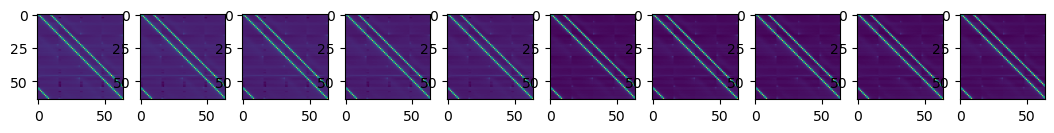

In [58]:
fig, ax = plt.subplots(1, 10, figsize=(13, 5))

egnd_data_d_40 = list()
clrng_d_40 = list()

for i, ele in enumerate(empty_d_40):
    tmp = np.load(ele, allow_pickle=True)
    pot = get_measured_potential(tmp, shape_type="vector")
    egnd_data_d_40.append(pot)
    clrng_d_40.append(40)
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

clrng_d_40 = np.array(clrng_d_40)
egnd_data_d_40 = np.array(egnd_data_d_40)

In [24]:
# compute the mean
mean_egnd_d_20 = np.mean(egnd_data_d_20, axis=0)
mean_egnd_d_30 = np.mean(egnd_data_d_30, axis=0)
mean_egnd_d_40 = np.mean(egnd_data_d_40, axis=0)

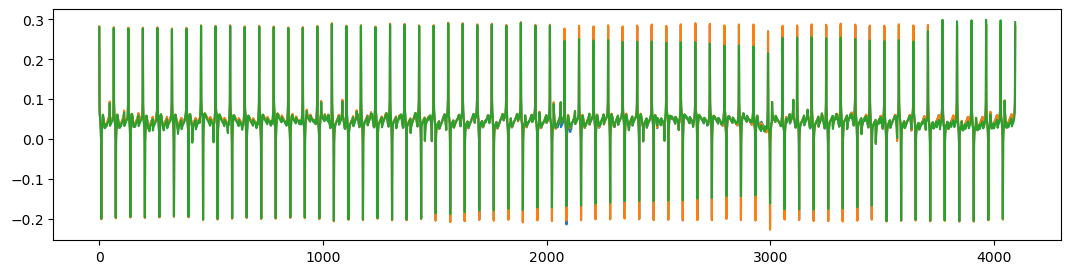

In [25]:
# plot all mean signals
plt.figure(figsize=(13, 3))
plt.plot(np.real(mean_egnd_d_20), color="C0")
plt.plot(np.real(mean_egnd_d_30), color="C1")
plt.plot(np.real(mean_egnd_d_40), color="C2")
plt.show()

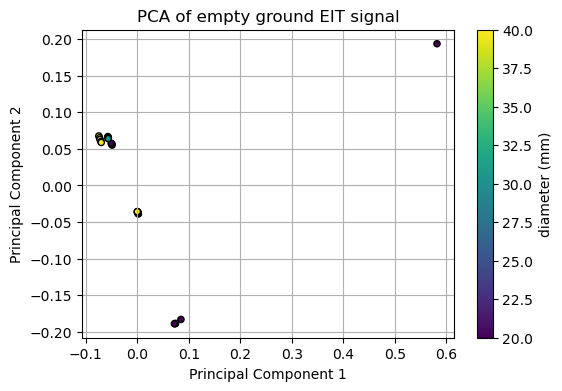

In [26]:
# plot the PCA of all empty ground measurements

gt_clrng = np.concatenate((clrng_d_20, clrng_d_30, clrng_d_40))
mean_egnd = np.concatenate((egnd_data_d_20, egnd_data_d_30, egnd_data_d_40))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.abs(mean_egnd))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gt_clrng, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of empty ground EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

In [38]:
# load all data points
d_20 = np.sort(glob.glob("measurements/messing_skip_8_d_20/data/*npz"))
d_30 = np.sort(glob.glob("measurements/messing_skip_8_d_30/data/*npz"))
d_40 = np.sort(glob.glob("measurements/messing_skip_8_d_40/data/*npz"))

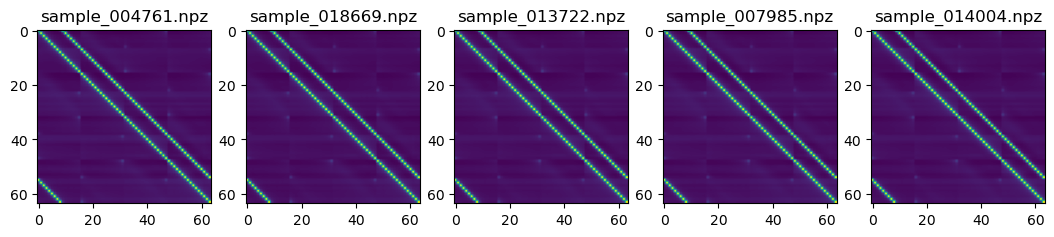

In [55]:
# plot five random datapoints from d_20/d_30/d_40
fig, ax = plt.subplots(1, 5, figsize=(13, 5))
for i in range(5):
    rand_ele = random.choice(d_20)
    tmp = np.load(rand_ele, allow_pickle=True)
    ax[i].set_title(rand_ele.split("/")[-1])
    ax[i].imshow(np.abs(get_measured_potential(tmp)))
plt.show()

In [40]:
data_d_20 = list()
data_d_20_abs = list()
d_d_20 = list()

for ele in tqdm(d_20[::]):
    tmp = np.load(ele, allow_pickle=True)

    pot = get_measured_potential(tmp, shape_type="vector")

    data_d_20.append(pot - mean_egnd_d_20)
    data_d_20_abs.append(pot)

    d_d_20.append(tmp["anomaly"].tolist().d)

data_d_20 = np.array(data_d_20)
data_d_20_abs = np.array(data_d_20_abs)
d_d_20 = np.array(d_d_20)

100%|██████████| 20700/20700 [10:19<00:00, 33.42it/s]


In [41]:
data_d_30 = list()
data_d_30_abs = list()
d_d_30 = list()

for ele in tqdm(d_30[::]):
    tmp = np.load(ele, allow_pickle=True)

    pot = get_measured_potential(tmp, shape_type="vector")

    data_d_30.append(pot - mean_egnd_d_30)
    data_d_30_abs.append(pot)

    d_d_30.append(tmp["anomaly"].tolist().d)

data_d_30 = np.array(data_d_30)
data_d_30_abs = np.array(data_d_30_abs)
d_d_30 = np.array(d_d_30)

100%|██████████| 20700/20700 [11:24<00:00, 30.22it/s]


In [ ]:
data_d_40 = list()
data_d_40_abs = list()
d_d_40 = list()

for ele in tqdm(d_40[::]):
    tmp = np.load(ele, allow_pickle=True)

    pot = get_measured_potential(tmp, shape_type="vector")

    data_d_40.append(pot - mean_egnd_d_40)
    data_d_40_abs.append(pot)

    d_d_40.append(tmp["anomaly"].tolist().d)

data_d_40 = np.array(data_d_40)
data_d_40_abs = np.array(data_d_40_abs)
d_d_40 = np.array(d_d_40)

 59%|█████▉    | 12279/20700 [06:36<05:02, 27.80it/s]

In [49]:
X = np.concatenate((data_d_20, data_d_30, data_d_40))
X_abs = np.concatenate((data_d_20_abs, data_d_30_abs, data_d_40_abs))
y = np.concatenate((d_d_20, d_d_30, d_d_40))

print(X.shape, y.shape)

(62100, 4096) (62100,)


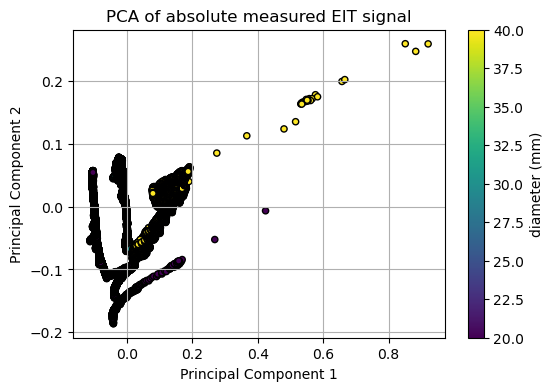

In [50]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.abs(X_abs))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of absolute measured EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

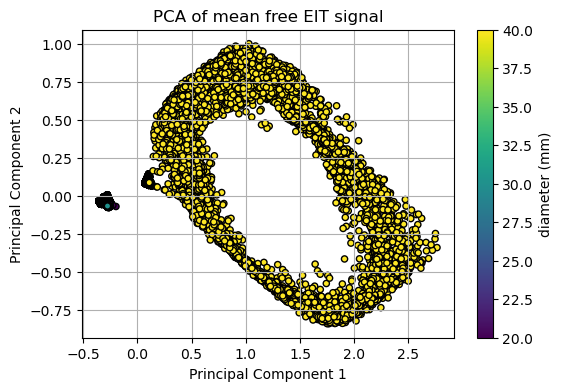

In [51]:
# PCA
pca = PCA(
    n_components=2
)  # You can change the number of components according to your needs
X_pca = pca.fit_transform(np.abs(X))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of mean free EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

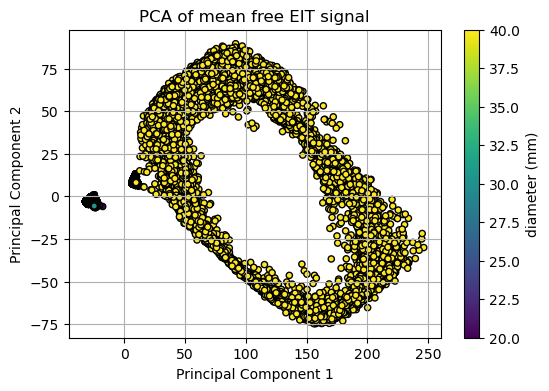

In [52]:
# PCA of the z-score normalization
pca = PCA(
    n_components=2
)  # You can change the number of components according to your needs
X_pca = pca.fit_transform((np.abs(X) - np.mean(np.abs(X))) / np.std(np.abs(X)))

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k", s=20)
plt.title("PCA of mean free EIT signal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="diameter (mm)")
plt.grid(True)
plt.show()

In [53]:
# Generate sample data (replace this with your own dataset)
pca = PCA(
    n_components=3
)  # You can change the number of components according to your needs
#X_pca = pca.fit_transform(np.abs(X_abs))
X_pca = pca.fit_transform(np.abs(X_abs))

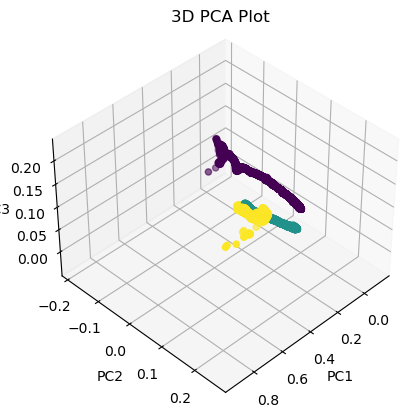

In [54]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.view_init(elev=40, azim=45)
plt.title("3D PCA Plot")
plt.show()

## $\rightarrow$ Take the mean free EIT measurements

### New approach:

Use one hot encoding $y_m=[0,0,1]$ for  $y_m=[d=10,d=20,d=30]$ for geometry size.

In [ ]:
# z-score normalization
z_score = True

if z_score:
    X = (np.abs(X) - np.mean(np.abs(X))) / np.std(np.abs(X))

In [ ]:
X_e = np.expand_dims(X, axis=2)
y_e = (y / 10) - 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_e, y_e, test_size=0.1, random_state=42, shuffle=True
)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(np.unique(y_train))

In [ ]:
Xscaler = Normalization(axis=2)  # oder 0?


def model(input_shape=(4096, 1), latent_dim=1, kernel=6, strides=4):
    mapper_input = Input(shape=input_shape)
    # normalize input data
    x = Xscaler(mapper_input)

    # convolutional layers
    x = Conv1D(1, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(2, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(4, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(8, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2, 4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(16, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2, 4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = Dense(latent_dim, activation="linear")(x)

    return Model(mapper_input, mapper_output)


model = model(latent_dim=1, kernel=6)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")
model.summary()

In [ ]:
es = EarlyStopping(monitor="loss", mode="min", patience=10, restore_best_weights=True)
Xscaler.adapt(X)  # X_train

history = model.fit(
    X_train,
    y_train,
    # validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=128,
    callbacks=[es],
    verbose=2,
)

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"])
plt.show()

In [ ]:
preds = (np.round(model.predict(X_test)) + 2) * 10

In [ ]:
cm = confusion_matrix((y_test + 2) * 10, preds)
# Plot confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["10", "20", "30"],
    yticklabels=["10", "20", "30"],
)
plt.xlabel("Predicted diameter (mm)")
plt.ylabel("True diameter (mm)")
plt.title("Confusion Matrix")
plt.show()